<a href="https://colab.research.google.com/github/elhamshaerirahbar-bot/my-colab-project/blob/main/Untitled13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas tensorflow

In [3]:
import numpy as np, pandas as pd, re, unicodedata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
import pandas as pd

# Just read the file
df = pd.read_csv('Exp_Mn_Mw_Value.txt', sep='\t')
print(df.head())

   Run  Factor A  Factor B  Factor C  Factor D  Response 1 (Experimental)  \
0    1       110         7        50        10                    1127.19   
1    2        85        13        50        10                    1024.97   
2    3       101         1       500        60                    1950.00   
3    4       101         1       500        60                    2223.17   
4    5        50        10        50        10                    1845.60   

   Response 2 (Experimental)  
0                    1321.65  
1                    1339.35  
2                    2878.90  
3                    2989.00  
4                    2690.50  


In [5]:
# Use iloc to select columns by position

X = df.iloc[:, 1:5].astype(float).to_numpy()  # columns 1-4 as features
y = df.iloc[:, 5:7].astype(float).to_numpy()  # Next 2 columns as targets

print("X:", X.shape, " y:", y.shape)

X: (25, 4)  y: (25, 2)


In [7]:
#Data splitting
# For 20% test, 16% val, 64% train:
SEED = 5  
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=True, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, shuffle=True, random_state=SEED  # 0.20 of 0.80 = 0.16 overall
)

In [8]:
#Scaling
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Ensure y has correct shape (samples, 2_targets)
assert y_train.ndim == 2 and y_train.shape[1] == 2, "y muss (n,2) sein"

# Scale features (X) using StandardScaler 
# Fit scaler only on training data to prevent data leakage
x_scaler = StandardScaler().fit(X_train)

# Transform all sets using the same scaler (mean=0, std=1)
X_train_z = x_scaler.transform(X_train)  # Standardized training features
X_val_z   = x_scaler.transform(X_val)    # Standardized validation features  
X_test_z  = x_scaler.transform(X_test)   # Standardized test features

#  Scale targets (y) to [-1,1] range for tanh activation
# Fit scaler only on training targets to prevent data leakage
y_scaler  = MinMaxScaler(feature_range=(-1, 1)).fit(y_train)  # y_train: (n,2)

# Transform all target sets using the same scaler
y_train_s = y_scaler.transform(y_train)  # Scaled training targets [-1,1]
y_val_s   = y_scaler.transform(y_val)    # Scaled validation targets [-1,1]
y_test_s  = y_scaler.transform(y_test)   # Scaled test targets [-1,1]

def inv_y(y_s):
    """
    Inverse transform scaled predictions back to original units.
    Args: y_s - scaled predictions in [-1,1] range
    Returns: predictions in original scale (Mn, Mw units)
    """
    return y_scaler.inverse_transform(y_s)

In [9]:
ann = tf.keras.models.Sequential()

In [10]:
#Build Neural Network: 4 inputs -> 3 hidden layers (16,8,8) -> 2 outputs
# Architecture: fully connected feedforward network with regularization
# Purpose: predict 2 molecular weight responses (Mn, Mw) from 4 factors

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Verify target shape (samples, 2_outputs)
assert y_train_s.ndim == 2 and y_train_s.shape[1] == 2, "y muss (n,2) sein!"

# Build neural network model
model = Sequential([
    # Input layer: 4 features -> 16 neurons
    # ReLU activation for non-linearity
    # L2 regularization to prevent overfitting
    layers.Dense(16, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5),
                 input_shape=(X_train_z.shape[1],)),
    
    # Dropout to reduce overfitting (randomly disable 10% of neurons)
    Dropout(0.1),
    
    # Hidden layer: 16 -> 8 neurons
    layers.Dense(8, activation='relu', 
                 kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.1),
    
    # Hidden layer: 8 -> 8 neurons  
    layers.Dense(8, activation='relu', 
                 kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.1),
    
    # Output layer: 8 -> 2 outputs (Mn, Mw)
    # Tanh activation outputs [-1,1] to match our scaled targets
    layers.Dense(2, activation='tanh')
])

# Compile model
# MSE loss for regression, MAE and MAPE as additional metrics
model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['mae', 'mape'])

C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile model with optimizer and loss function
model.compile(optimizer='adam',    # Adaptive learning rate optimizer
              loss='mse',          # Mean Squared Error for regression
              metrics=['mae', 'mape'])  # Track Mean Absolute Error and Mean Absolute Percentage Error

# Early stopping to prevent overfitting
# Stops training when validation loss doesn't improve for 25 epochs
# Restores the best weights found during training
early = EarlyStopping(monitor='val_loss',        # Watch validation loss
                     patience=25,                # Wait 25 epochs without improvement
                     restore_best_weights=True)  # Keep best model weights

# Train the model
# Uses scaled features (X_train_z) and scaled targets (y_train_s) in [-1,1] range
# Validates on separate validation set to monitor overfitting
history = model.fit(
    X_train_z, y_train_s,                    # Training data (scaled)
    validation_data=(X_val_z, y_val_s),     # Validation data (scaled)
    epochs=500,                              # Maximum 500 epochs
    batch_size=16,                           # Process 16 samples at a time
    verbose=1,                               # Print progress during training
    callbacks=[early]                        # Apply early stopping
)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.3090 - mae: 0.4278 - mape: 110.7342 - val_loss: 0.2823 - val_mae: 0.3777 - val_mape: 119.2936
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2986 - mae: 0.4261 - mape: 129.6580 - val_loss: 0.2773 - val_mae: 0.3733 - val_mape: 117.0840
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2592 - mae: 0.4011 - mape: 127.1232 - val_loss: 0.2737 - val_mae: 0.3697 - val_mape: 114.9165
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2847 - mae: 0.4077 - mape: 109.7059 - val_loss: 0.2693 - val_mae: 0.3657 - val_mape: 112.8975
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2792 - mae: 0.4114 - mape: 110.9016 - val_loss: 0.2658 - val_mae: 0.3621 - val_mape: 110.8175
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2420 - mae: 0.3817 - mape: 109.7000 - val_loss: 0.2607 - val_mae: 0.3576 - val_mape: 108.8064
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2958 - mae: 0.4115

In [12]:
# Make predictions on all sets
y_hat_train_s = model.predict(X_train_z)
y_hat_val_s   = model.predict(X_val_z)
y_hat_test_s  = model.predict(X_test_z)

# Convert predictions back to original scale
y_hat_train = inv_y(y_hat_train_s)
y_hat_val   = inv_y(y_hat_val_s)
y_hat_test  = inv_y(y_hat_test_s)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [13]:
#Evaluate code performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def report_2out(name, y_true, y_pred, labels=("Mn", "Mw")):
    """
    Calculate and print regression metrics for 2-output model
    Args: name - dataset name, y_true/y_pred - shape (n,2), labels - output names
    """
    for i, label in enumerate(labels):
        # Extract single output column
        yt = y_true[:, i]
        yp = y_pred[:, i]
        
        # Calculate metrics
        mae  = mean_absolute_error(yt, yp)
        mse  = mean_squared_error(yt, yp)
        r2   = r2_score(yt, yp)
        mape = mean_absolute_percentage_error(yt, yp)
        
        # Print results
        print(f"[{name}] {label}: MAE={mae:.6f}  MSE={mse:.6f}  R²={r2:.4f}  MAPE={mape:.6f}")

In [14]:
#print metrics
report_2out("Train", y_train, y_hat_train)
report_2out("Val  ", y_val,   y_hat_val)
report_2out("Test ", y_test,  y_hat_test)

[Train] Mn: MAE=160.151855  MSE=38833.078926  R²=0.9249  MAPE=0.064455
[Train] Mw: MAE=279.137066  MSE=117677.247310  R²=0.9087  MAPE=0.098560
[Val  ] Mn: MAE=136.180398  MSE=26586.174508  R²=0.9401  MAPE=0.083220
[Val  ] Mw: MAE=298.984687  MSE=195193.671561  R²=0.7071  MAPE=0.184854
[Test ] Mn: MAE=968.564535  MSE=2104017.658424  R²=-0.0418  MAPE=0.228543
[Test ] Mw: MAE=1232.024797  MSE=3175572.242193  R²=0.0070  MAPE=0.253384


In [15]:
!pip install matplotlib

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Create detailed comparison table showing actual vs predicted values
# Shows sample-by-sample performance for both outputs (Mn, Mw) across all datasets
# Includes error metrics: residual, absolute error, and percentage error

import numpy as np
import pandas as pd

def make_table_multi(split, y_true, y_pred, target_names=("Mn","Mw"), n=None):
    """Create comparison table for actual vs predicted values"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    parts = []
    for j, name in enumerate(target_names):
        df = pd.DataFrame({
            "split":     split,
            "target":    name,
            "actual":    y_true[:, j],
            "predicted": y_pred[:, j],
        })
        # Calculate error metrics
        df["residual"]  = df["actual"] - df["predicted"]
        df["abs_error"] = df["residual"].abs()
        df["pct_error"] = 100 * df["abs_error"] / df["actual"].abs().clip(lower=1e-8)
        
        parts.append(df if n is None else df.head(n))
    
    return pd.concat(parts, ignore_index=True)

# Create comparison tables for all datasets
tbl_train = make_table_multi("Train", y_train, y_hat_train)
tbl_val   = make_table_multi("Val",   y_val,   y_hat_val)
tbl_test  = make_table_multi("Test",  y_test,  y_hat_test)

# Combine all tables
tbl_all = pd.concat([tbl_train, tbl_val, tbl_test], ignore_index=True)
print(tbl_all.to_string(index=False))

split target   actual   predicted    residual   abs_error  pct_error
Train     Mn 1845.600 1945.874634 -100.274634  100.274634   5.433173
Train     Mn 2590.790 2575.164062   15.625937   15.625937   0.603134
Train     Mn 2074.517 2165.433105  -90.916105   90.916105   4.382519
Train     Mn 2955.830 2675.055908  280.774092  280.774092   9.498993
Train     Mn 2298.620 2629.554443 -330.934443  330.934443  14.397092
Train     Mn 2525.270 2552.159912  -26.889912   26.889912   1.064833
Train     Mn 2752.840 2674.102783   78.737217   78.737217   2.860218
Train     Mn 1846.180 1945.874634  -99.694634   99.694634   5.400049
Train     Mn 1127.190 1133.361816   -6.171816    6.171816   0.547540
Train     Mn 2322.830 2440.811523 -117.981523  117.981523   5.079215
Train     Mn 3764.530 3469.653076  294.876924  294.876924   7.833034
Train     Mn 2073.900 2165.433105  -91.533105   91.533105   4.413574
Train     Mn 1264.440 1137.396118  127.043882  127.043882  10.047442
Train     Mn 3762.880 3469.653076 

In [17]:
#testing other activation function from ANN
import random, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, optimizers

activations = ['relu', 'tanh', 'sigmoid', 'softplus']
labels      = ['ReLU', 'Tanh', 'Sigmoid', 'Softplus']

val_mse_real  = []
test_mse_real = []

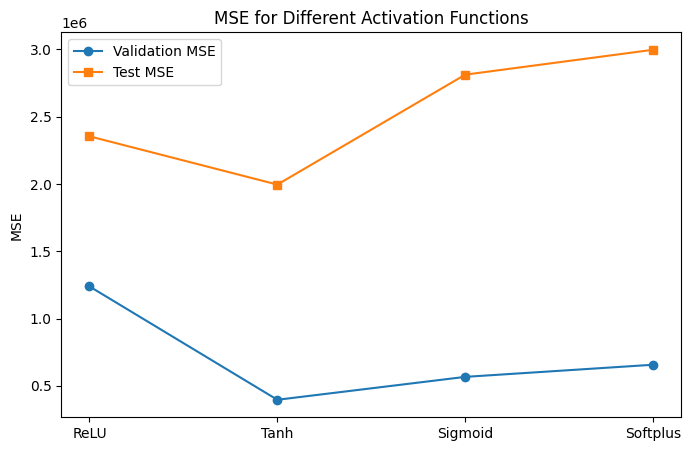

In [19]:
SEED = 5  # for reproducibility

for act in activations:
    # Reset state
    tf.keras.backend.clear_session()
    np.random.seed(SEED)
    random.seed(SEED)
    tf.random.set_seed(SEED)

    # Build model
    model = tf.keras.Sequential([
        layers.Input(shape=(X_train_z.shape[1],)),
        layers.Dense(16, activation=act),
        layers.Dense(2, activation='tanh')  # 2 outputs: [Mn, Mw]
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='mse', metrics=['mae'])

    # Train
    history = model.fit(
        X_train_z, y_train_s,
        validation_data=(X_val_z, y_val_s),
        epochs=200, batch_size=16, shuffle=True, verbose=0
    )

    # Predict (scaled)
    y_hat_val_s  = model.predict(X_val_z, verbose=0)
    y_hat_test_s = model.predict(X_test_z, verbose=0)

    # Inverse transform to real units
    y_hat_val  = inv_y(y_hat_val_s)
    y_hat_test = inv_y(y_hat_test_s)

    # Compute MSE in real units
    val_mse_real.append(mean_squared_error(y_val, y_hat_val))
    test_mse_real.append(mean_squared_error(y_test, y_hat_test))

# Plot results
plt.figure(figsize=(8,5))
plt.plot(labels, val_mse_real, marker='o', label='Validation MSE')
plt.plot(labels, test_mse_real, marker='s', label='Test MSE')
plt.ylabel('MSE')
plt.title('MSE for Different Activation Functions')
plt.legend()
plt.show()
